# IDH

In [1]:
%matplotlib inline
import pandas as pd
import requests as req
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols, mixedlm, gee
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from patsy import dmatrix

np.set_printoptions(precision=3)

### Carregando dados de IDH-M da Wikipedia

#### Fontes

Estados: http://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH

In [2]:
idhm_df = pd.read_csv("../data/brazil_states_idhe_2000_2010.csv", index_col=0)
idhm_df

,Estado,I2000,I2010,Ratio,idh_level_2000
0,Distrito Federal,0.582,0.742,1.274914,1
1,São Paulo,0.581,0.719,1.237522,1
2,Santa Catarina,0.526,0.697,1.325095,1
3,Rio de Janeiro,0.530,0.675,1.273585,1
4,Paraná,0.522,0.668,1.279693,1
5,Espírito Santo,0.491,0.653,1.329939,1
6,Goiás,0.439,0.646,1.471526,1
7,Rio Grande do Sul,0.505,0.642,1.271287,1
8,Minas Gerais,0.470,0.638,1.357447,1
9,Mato Grosso,0.426,0.635,1.490610,1


### Análise

In [3]:
idhm_df.describe()

,I2000,I2010,Ratio,idh_level_2000
count,27.000000,27.000000,27.000000,27.000000
mean,0.411296,0.612407,1.528907,0.518519
std,0.090187,0.058295,0.196346,0.509175
min,0.282000,0.520000,1.237522,0.000000
25%,0.331500,0.560500,1.343693,0.000000
50%,0.396000,0.624000,1.507576,1.000000
75%,0.480500,0.644000,1.674600,1.000000
max,0.582000,0.742000,1.843972,1.000000


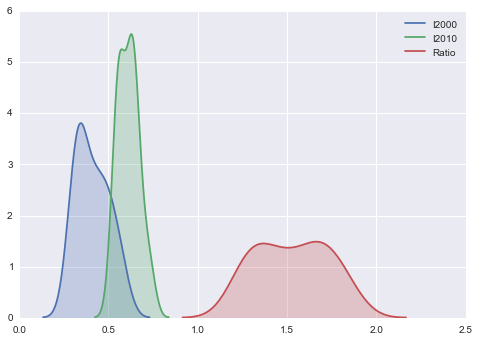

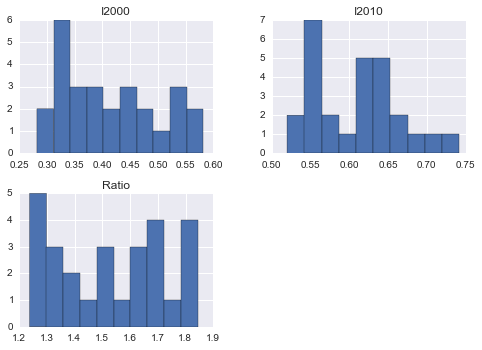

In [4]:
f = plt.figure(14)
idhm_df[["I2000","I2010","Ratio"]].hist(bins=10)
plt.figure()
sns.kdeplot(idhm_df["I2000"], shade=True);
sns.kdeplot(idhm_df["I2010"], shade=True);
sns.kdeplot(idhm_df["Ratio"], shade=True);

### Testando hipótese

#### A diferença média entre os IDHs de 2000 e 2010 é estatisticamente significativa?

In [5]:
ttest_rel(idhm_df['I2000'], idhm_df['I2010'])

(-27.266286999353952, 1.1789821352121643e-20)

In [6]:
import scipy  
import scikits.bootstrap as bootstrap
  
# compute 95% confidence intervals around the mean  
CIs00 = bootstrap.ci(data=idhm_df["I2000"])  
CIs10 = bootstrap.ci(data=idhm_df["I2010"])
CIsR  = bootstrap.ci(data=idhm_df["Ratio"])

print("IDHM 2000 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 mean 95% confidence interval. Low=0.380	High=0.446
IDHM 2010 mean 95% confidence interval. Low=0.592	High=0.635
IDHM ratio mean 95% confidence interval. Low=1.457	High=1.601


In [7]:
CIs00 = bootstrap.ci(data=idhm_df["I2000"], statfunction=scipy.median)  
CIs10 = bootstrap.ci(data=idhm_df["I2010"], statfunction=scipy.median)
CIsR  = bootstrap.ci(data=idhm_df["Ratio"], statfunction=scipy.median)

print("IDHM 2000 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 median 95% confidence interval. Low=0.332	High=0.445
IDHM 2010 median 95% confidence interval. Low=0.561	High=0.635
IDHM ratio median 95% confidence interval. Low=1.357	High=1.655


A resposta de diversos testes, para um nível de 5% de significância, mostra que há fortes evidências que **sim**.

### Montando percentual de impacto da administração de cada partido em cada Estado da Federação.

In [8]:
state_parties_df = pd.read_csv("../data/brazil_states_parties_2000-2010.csv", index_col=0)


In [9]:
state_parties_df

,Estado,Outros,PSDB,PT
0,Distrito Federal,1.000,0.000,0.000
1,São Paulo,0.075,0.925,0.000
2,Santa Catarina,1.000,0.000,0.000
3,Rio de Janeiro,0.600,0.000,0.400
4,Paraná,1.000,0.000,0.000
5,Rio Grande do Sul,0.400,0.400,0.200
6,Espírito Santo,0.800,0.200,0.000
7,Goiás,0.400,0.600,0.000
8,Minas Gerais,0.200,0.800,0.000
9,Mato Grosso do Sul,0.400,0.600,0.000


In [10]:
state_regions_df = pd.read_csv("../data/brazil_states_regions.csv", index_col=0)
state_regions_df

,Estado,Regiao
0,Distrito Federal,Centro-Oeste
1,São Paulo,Sudeste
2,Santa Catarina,Sul
3,Rio de Janeiro,Sudeste
4,Paraná,Sul
5,Rio Grande do Sul,Sul
6,Espírito Santo,Sudeste
7,Goiás,Centro-Oeste
8,Minas Gerais,Sudeste
9,Mato Grosso do Sul,Centro-Oeste


In [11]:
df = idhm_df.merge(state_parties_df, on="Estado")
df = df.merge(state_regions_df, on="Estado")
df

,Estado,I2000,I2010,Ratio,idh_level_2000,Outros,PSDB,PT,Regiao
0,Distrito Federal,0.582,0.742,1.274914,1,1.000,0.000,0.000,Centro-Oeste
1,São Paulo,0.581,0.719,1.237522,1,0.075,0.925,0.000,Sudeste
2,Santa Catarina,0.526,0.697,1.325095,1,1.000,0.000,0.000,Sul
3,Rio de Janeiro,0.530,0.675,1.273585,1,0.600,0.000,0.400,Sudeste
4,Paraná,0.522,0.668,1.279693,1,1.000,0.000,0.000,Sul
5,Espírito Santo,0.491,0.653,1.329939,1,0.800,0.200,0.000,Sudeste
6,Goiás,0.439,0.646,1.471526,1,0.400,0.600,0.000,Centro-Oeste
7,Rio Grande do Sul,0.505,0.642,1.271287,1,0.400,0.400,0.200,Sul
8,Minas Gerais,0.470,0.638,1.357447,1,0.200,0.800,0.000,Sudeste
9,Mato Grosso,0.426,0.635,1.490610,1,0.800,0.200,0.000,Centro-Oeste


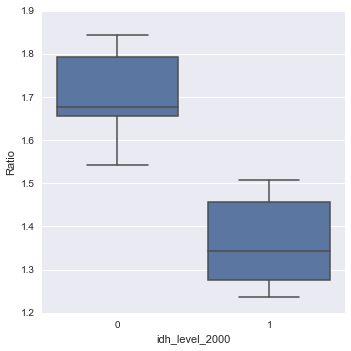

In [12]:
sns.factorplot("idh_level_2000","Ratio",data=df, kind="box")

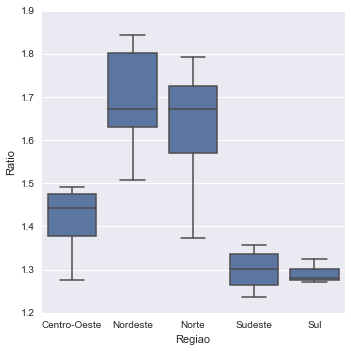

In [13]:
sns.factorplot("Regiao","Ratio",data=df, kind="box")

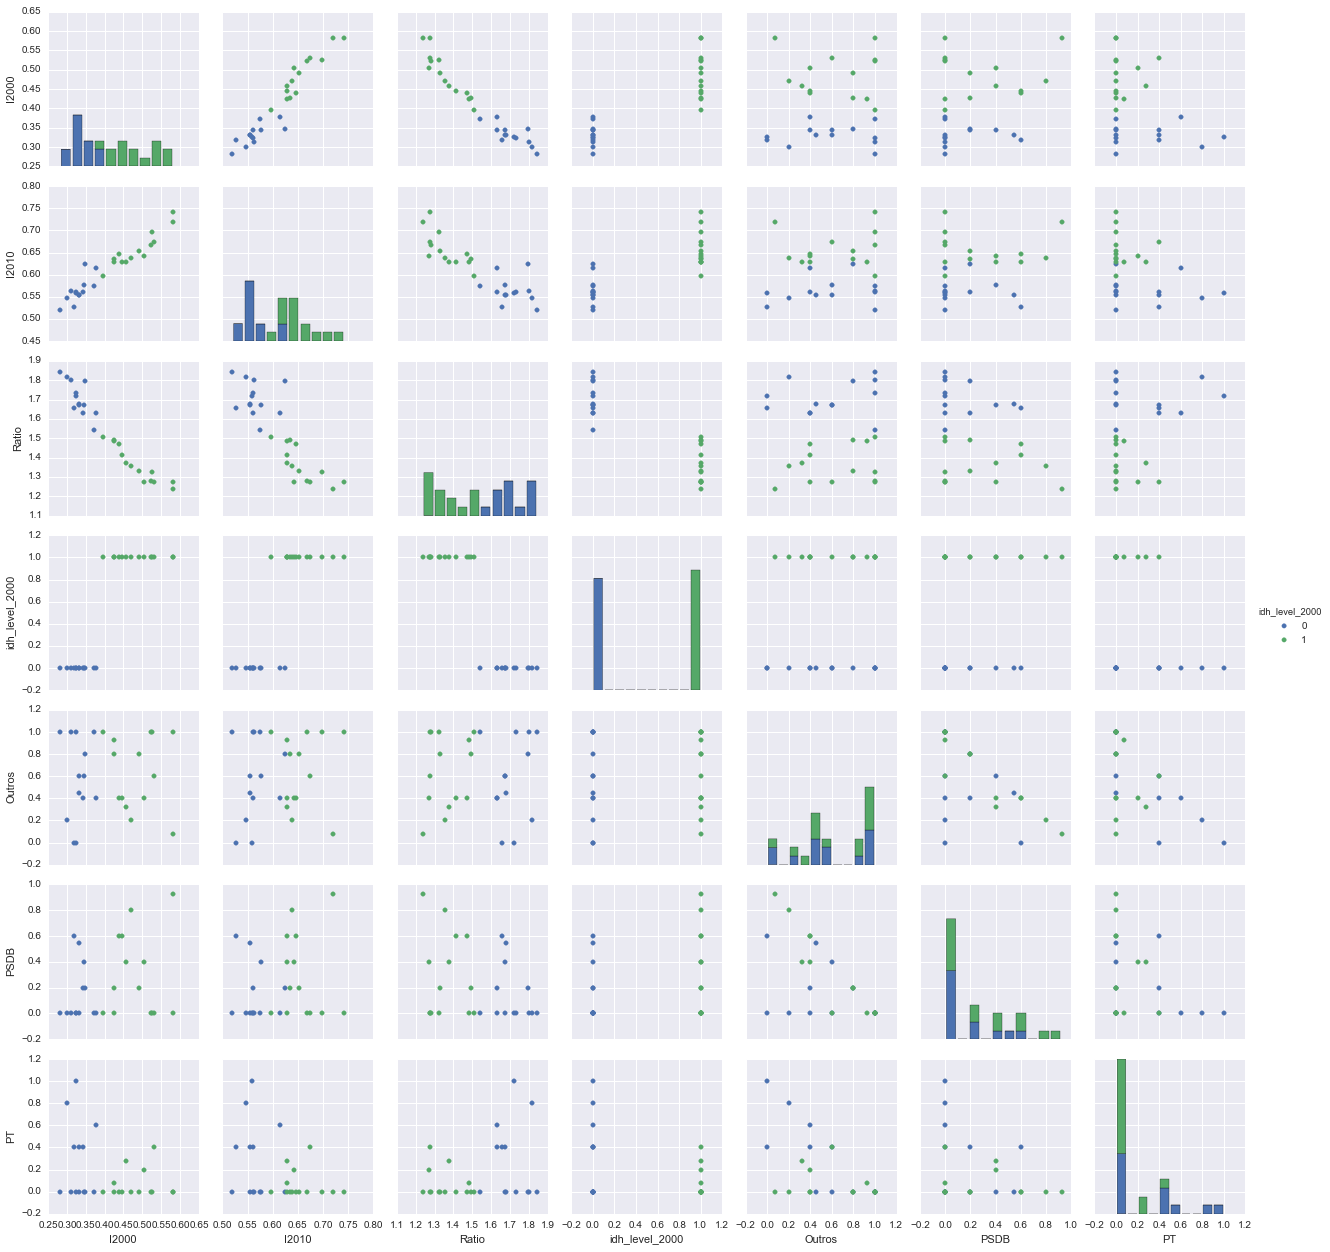

In [14]:
sns.set()
sns.pairplot(df, hue="idh_level_2000", size=2.5)

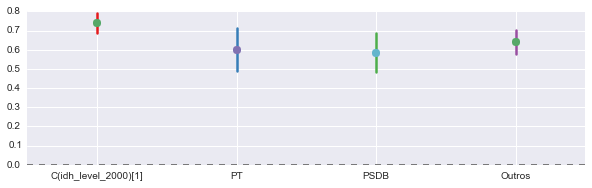

In [15]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");

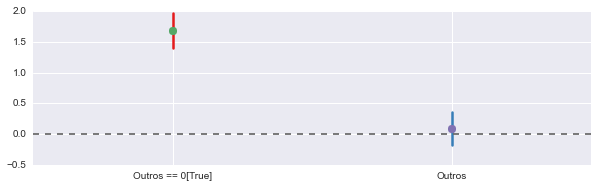

In [16]:
sns.coefplot("Ratio ~ Outros==0 + Outros - 1", df, palette="Set1");

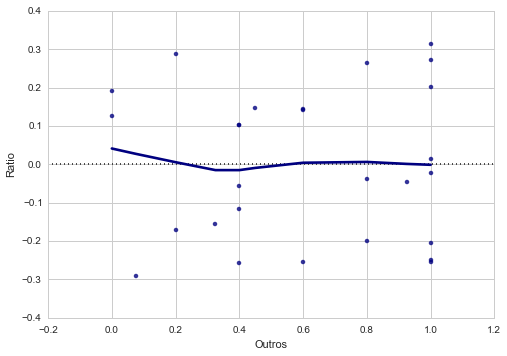

In [17]:
sns.set(style="whitegrid")
sns.residplot(df.Outros,df.Ratio, color="navy", lowess=True, order=1)

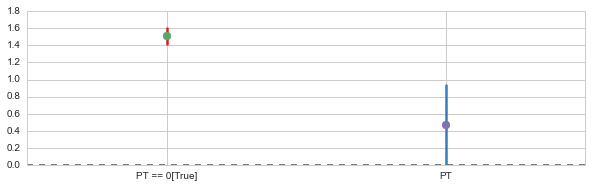

In [18]:
sns.coefplot("Ratio ~ PT==0 + PT - 1", df, palette="Set1");

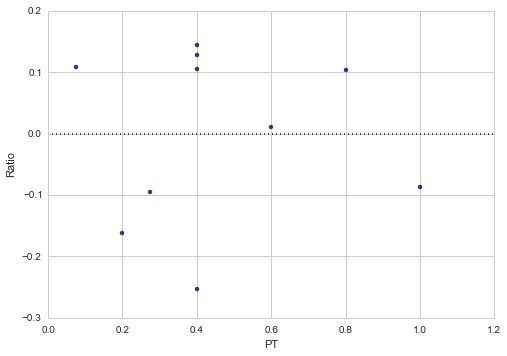

In [19]:
sns.set(style="whitegrid")
sns.residplot(df[df.PT>0].PT, df[df.PT>0].Ratio, color="navy", order=1)

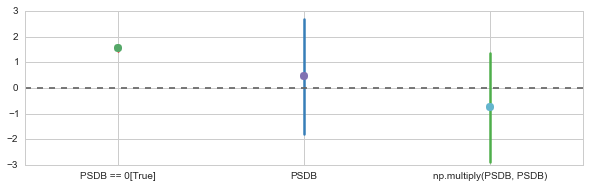

In [20]:
sns.coefplot("Ratio ~ PSDB==0 + PSDB + np.multiply(PSDB, PSDB) - 1", df, palette="Set1");

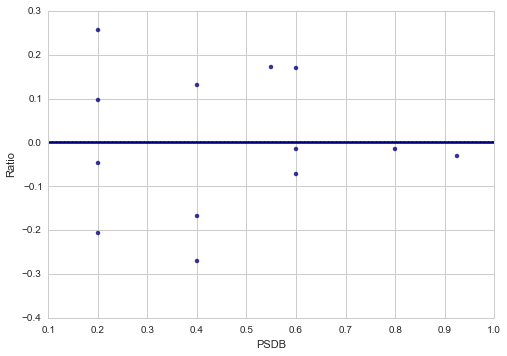

In [21]:
sns.set(style="whitegrid")
sns.residplot(df[df.PSDB>0].PSDB, df[df.PSDB>0].Ratio, color="navy", lowess=True, order=2)

### Impacto por partido ou nível do IDH-M em 2000

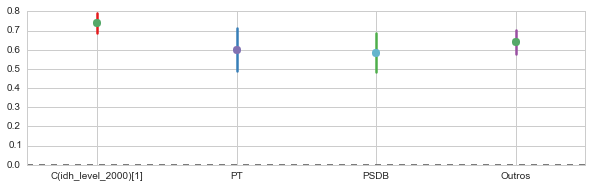

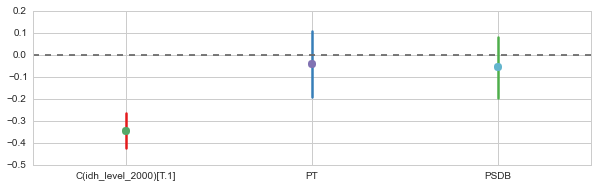

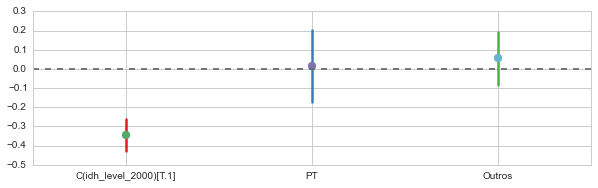

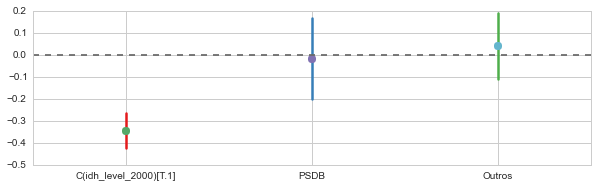

In [22]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");
sns.coefplot("Ratio ~ PT + PSDB + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PT + Outros + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PSDB + Outros + C(idh_level_2000)", df, palette="Set1");

In [23]:
formula = "Ratio ~ PT + PSDB + C(idh_level_2000) + C(Regiao)"
model = ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ratio   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     17.02
Date:                Wed, 20 May 2015   Prob (F-statistic):           5.96e-07
Time:                        00:06:33   Log-Likelihood:                 32.932
No. Observations:                  27   AIC:                            -49.86
Df Residuals:                      19   BIC:                            -39.50
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  1.6846      0.077     21.768      0.000         1.523     1.847
C(idh_level_2000)[T.1]    -0.2586      0.057     -4.504      0.000        -0.379    -0.138
C(Regiao)[T.Nordeste]      0.0359      0.075      0.482      0.635        -0.120     0.192
C(Regiao)[T.Norte]         0.0391      0.068      0.575      0.572        -0.103     0.181
C(Regiao)[T.Sudeste]      -0.1047      0.061     -1.704      0.105        -0.233     0.024
C(Regiao)[T.Sul]          -0.1267      0.067     -1.900      0.073        -0.266     0.013
PT                        -0.0329      0.067     -0.489      0.630        -0.174     0.108
PSDB                      -0.0382      0.068     -0.558      0.583        -0.181     0.105
==============================================================================
Omnibus:                        1.697   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.428   Jarque-Bera (JB):                0.920
Skew:                          -0.448   Prob(JB):                        0.631
Kurtosis:                       3.130   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Não foi possível observar diferença significantiva entre os partidos.**

### Quais estados possuem diferença significativa?

Comparando 2010 com 2000

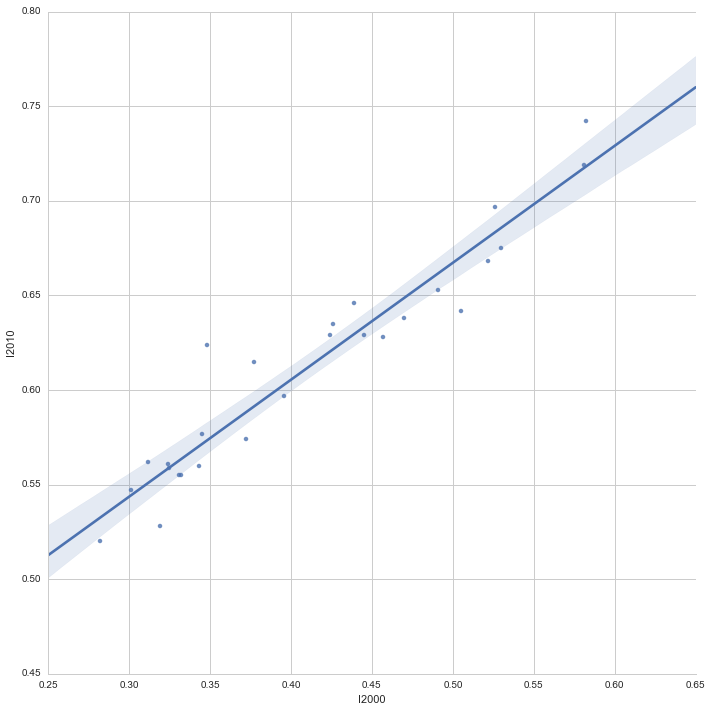

In [24]:
sns.lmplot("I2000", "I2010", data=df, legend=True, size=10, n_boot=10000, ci=95)

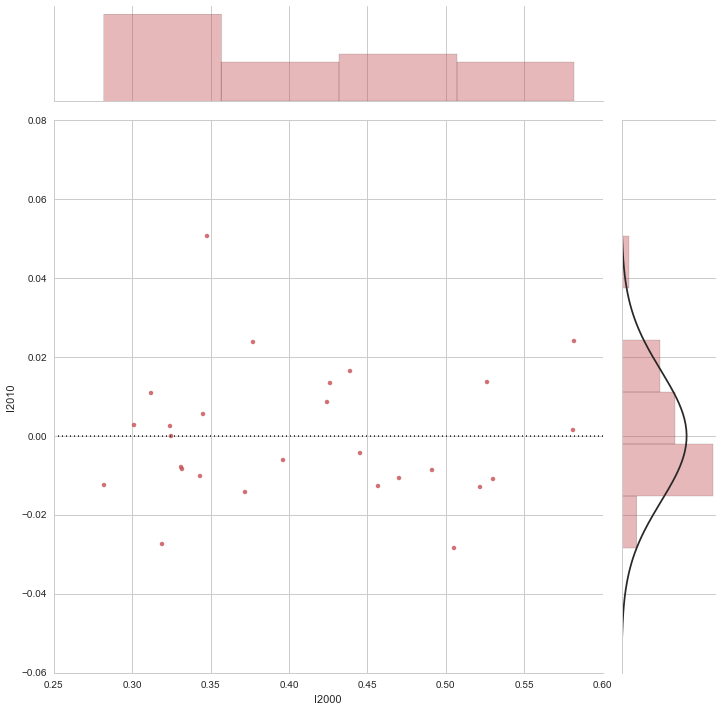

In [25]:
sns.jointplot("I2000", "I2010", data=df, kind='resid',color=sns.color_palette()[2], size=10)

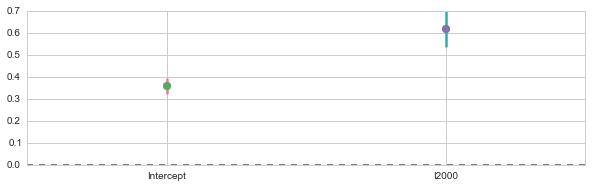

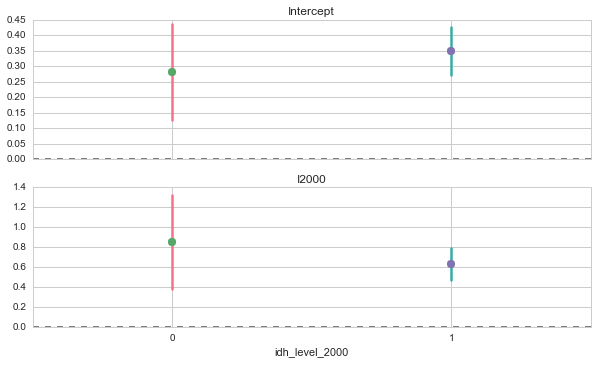

In [26]:
sns.coefplot("I2010 ~ I2000", data=df, intercept=True)
sns.coefplot("I2010 ~ I2000", data=df, groupby="idh_level_2000", intercept=True)

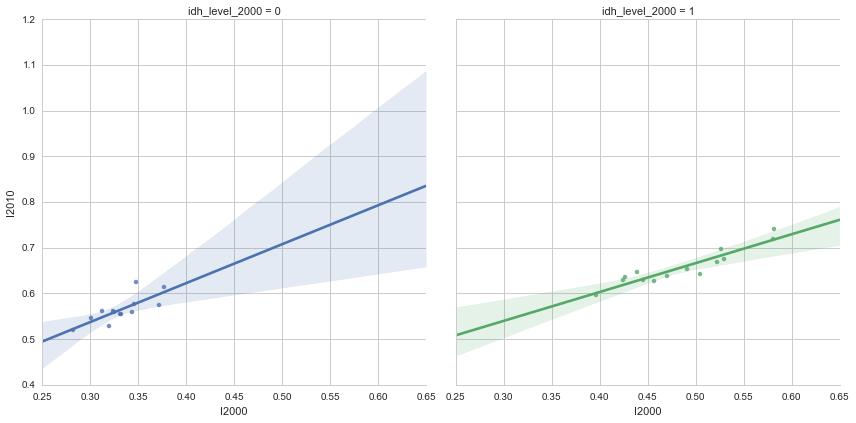

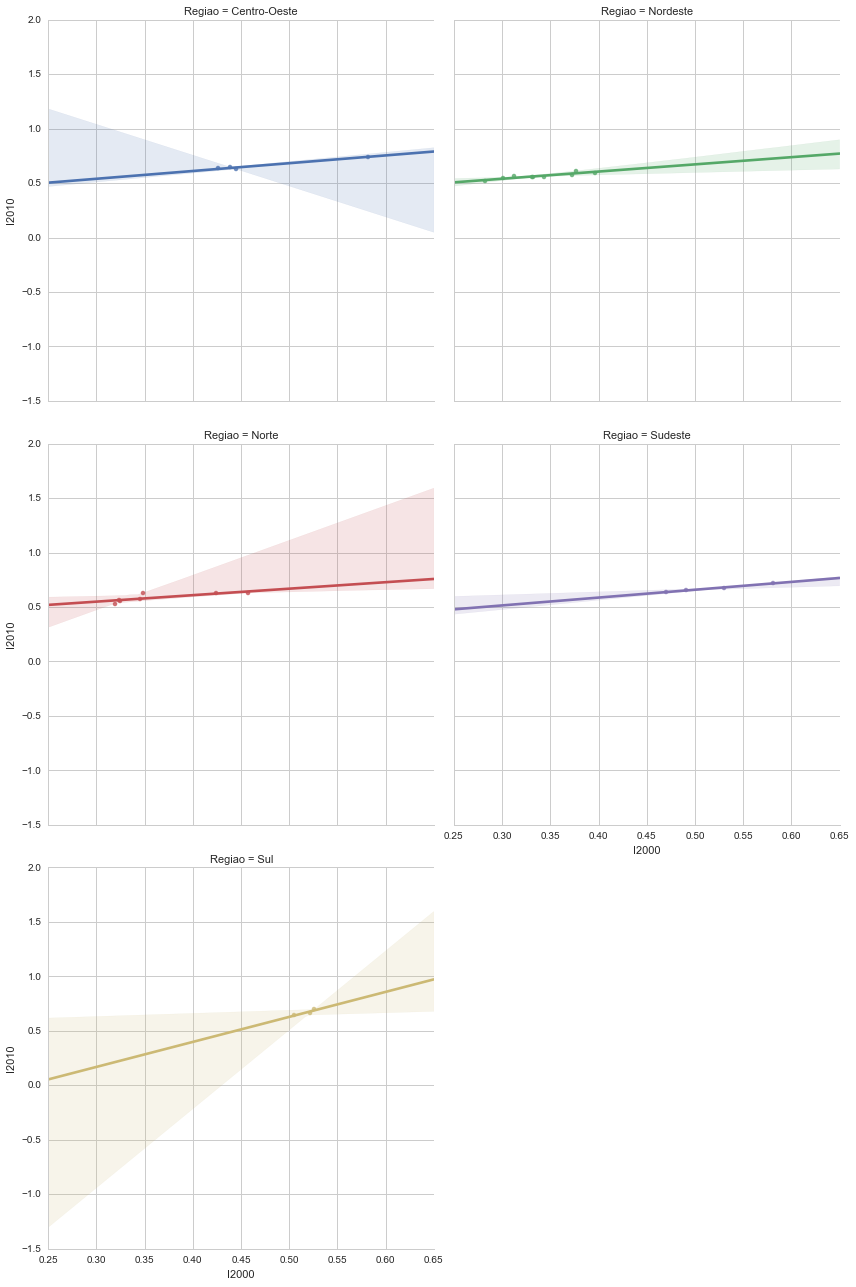

In [27]:
sns.lmplot("I2000", "I2010", data=df, hue="idh_level_2000", col="idh_level_2000", legend=True, size=6, n_boot=10000, ci=99)
sns.lmplot("I2000", "I2010", data=df, hue="Regiao", col="Regiao", col_wrap=2, legend=True, size=6, n_boot=10000, ci=99)

In [28]:
md = ols("I2010 ~ I2000 + C(Regiao)", df).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                  I2010   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     57.11
Date:                Wed, 20 May 2015   Prob (F-statistic):           1.64e-11
Time:                        00:06:47   Log-Likelihood:                 75.131
No. Observations:                  27   AIC:                            -138.3
Df Residuals:                      21   BIC:                            -130.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.34

In [29]:
rrr = md.get_robustcov_results()
rrp = rrr.outlier_test("fdr_bh", 0.1)
idx = rrp[rrp["fdr_bh(p)"] <= 0.1].index
print("Estados fora da média:\n",df.ix[idx.values])
rrp[rrp["fdr_bh(p)"] <= 0.1]

Estados fora da média:
        Estado  I2000  I2010     Ratio  idh_level_2000  Outros  PSDB  PT Regiao
13  Tocantins  0.348  0.624  1.793103               0     0.8   0.2   0  Norte


,student_resid,unadj_p,fdr_bh(p)
13,3.952889,0.000785,0.021207


### GEE

In [30]:
import statsmodels.api as sm
md = gee("Ratio ~ PT + PSDB ", df.idh_level_2000, df, cov_struct=sm.cov_struct.Exchangeable()) 
mdf = md.fit() 
print(mdf.summary())
print(mdf.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                       Ratio   No. Observations:                   27
Model:                                 GEE   No. clusters:                        2
Method:                        Generalized   Min. cluster size:                  13
                      Estimating Equations   Max. cluster size:                  14
Family:                           Gaussian   Mean cluster size:                13.5
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Wed, 20 May 2015   Scale:                           0.041
Covariance type:                    robust   Time:                         00:06:48
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.5539      0.121     12.823      0.000         1.316     1.791
PT     

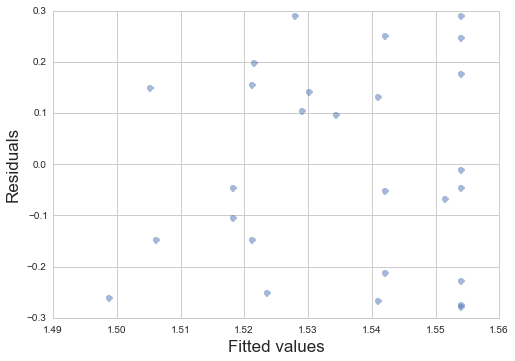

In [31]:
plt.plot(mdf.fittedvalues, mdf.resid, 'o', alpha=0.5)
plt.xlabel("Fitted values", size=17)
plt.ylabel("Residuals", size=17)

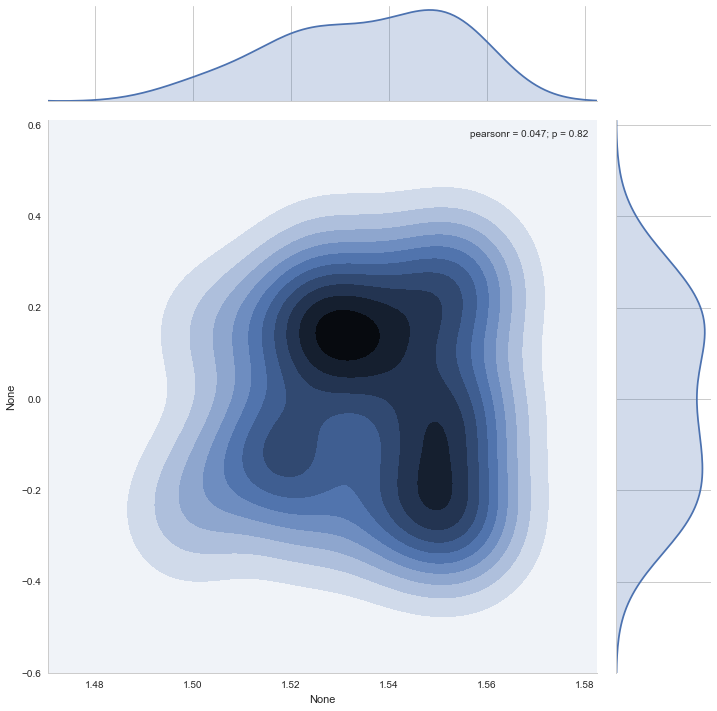

In [32]:
sns.jointplot(mdf.fittedvalues, mdf.resid, size=10, kind="kde")